# ARIMA and GARCH

### Dependencies, Data and Hyperparameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from arch.data import sp500
import warnings
warnings.filterwarnings("ignore")

TRAIN_TEST_SPLIT = 0.95
ARIMA_PARAMETER_SELECTION = 'aic'
GARCH_PARAMETER_SELECTION = 'aic'
ARIMA_PERIOD = 135
GARCH_PERIOD = 135

data = pd.read_csv('ONGC_Adjusted.csv')
train, test = np.split(data['Close'], [int(TRAIN_TEST_SPLIT*len(data))])
log_returns = np.log(train).diff().dropna()

### Determining parameters and fitting ARIMA and GARCH

In [ ]:

# Determining d via ADF
def adf_test(series, alpha=0.05):
    """Return True if stationary, False otherwise"""
    result = adfuller(series, autolag='AIC')
    pval = result[1]
    return pval < alpha

d = 0
series = log_returns.iloc[-1*ARIMA_PERIOD:].copy()
while not adf_test(series):
    d += 1
    series = series.diff().dropna()
print(f"Optimal differencing order determined: d = {d}")

# Determining (p,_,q) via AIC/BIC
p_max = 10
q_max = 10
best_aic = np.inf
best_bic = np.inf
best_arima_order_aic = None
best_arima_order_bic = None

for p in range(1, p_max+1):
    for q in range(1, q_max+1):
        try:
            model = sm.tsa.ARIMA(log_returns.iloc[-1*ARIMA_PERIOD:], order=(p,d,q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_arima_order_aic = (p,d,q)
            if result.bic < best_bic:
                best_bic = result.bic
                best_arima_order_bic = (p,d,q)
        except:
            continue
print(f"Optimal ARIMA order determined: {best_arima_order_aic} with AIC={best_aic:.2f}")
print(f"Optimal ARIMA order determined: {best_arima_order_bic} with BIC={best_bic:.2f}")

if ARIMA_PARAMETER_SELECTION=='aic':
    best_arima_order = best_arima_order_aic
else:
    best_arima_order = best_arima_order_bic

best_arima_order = (2,0,2)

# Fitting ARIMA
arima_model = sm.tsa.ARIMA(log_returns.iloc[-1*ARIMA_PERIOD:], order=best_arima_order)
arima_result = arima_model.fit()
residuals = arima_result.resid.dropna()

# Determining (p,q) via AIC/BIC
garch_p_max = 10
garch_q_max = 10
best_aic_garch = np.inf
best_bic_garch = np.inf
best_garch_order_aic = None
best_garch_order_bic = None

for p in range(1, garch_p_max+1):  # p>=1 in GARCH
    for q in range(1, garch_q_max+1):  # q>=1 in GARCH
        try:
            model = arch_model(residuals.iloc[-1*GARCH_PERIOD:], vol="GARCH", p=p, q=q, mean="Zero")
            result = model.fit(disp="off")
            if result.aic < best_aic_garch:
                best_aic_garch = result.aic
                best_garch_order_aic = (p,q)
            if result.bic < best_bic_garch:
                best_bic_garch = result.bic
                best_garch_order_bic = (p,q)
        except:
            continue
print(f"Optimal GARCH order determined: {best_garch_order_aic} with AIC={best_aic_garch:.2f}")
print(f"Optimal GARCH order determined: {best_garch_order_bic} with BIC={best_bic_garch:.2f}")

if GARCH_PARAMETER_SELECTION=='aic':
    best_garch_order = best_garch_order_aic
else:
    best_garch_order = best_garch_order_bic

# Fitting GARCH
garch_model = arch_model(residuals.iloc[-1*GARCH_PERIOD:], vol="GARCH", p=best_garch_order[0], q=best_garch_order[1], mean="Zero")
garch_result = garch_model.fit(disp="off")


Optimal differencing order determined: d = 0
Optimal ARIMA order determined: (5, 0, 3) with AIC=-752.97
Optimal ARIMA order determined: (1, 0, 2) with BIC=-737.77


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimal GARCH order determined: (1, 1) with AIC=-775.56
Optimal GARCH order determined: (1, 1) with BIC=-766.84


### Forecast

In [ ]:
# Forecast horizon
forecast_horizon = len(test)

# Forecasted mean (ARIMA)
arima_forecast = arima_result.get_forecast(steps=forecast_horizon)
arima_mean_forecast = arima_forecast.predicted_mean

# Forecasted volatility (GARCH)
garch_forecast = garch_result.forecast(horizon=forecast_horizon)
garch_vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

first_price = train.iloc[-1*ARIMA_PERIOD]
last_price = train.iloc[-1]
arima_fitted_prices = np.exp(np.log(first_price) + arima_result.fittedvalues.cumsum())
arima_forecasted_prices = np.exp(np.log(last_price) + arima_mean_forecast.cumsum())

### Plots

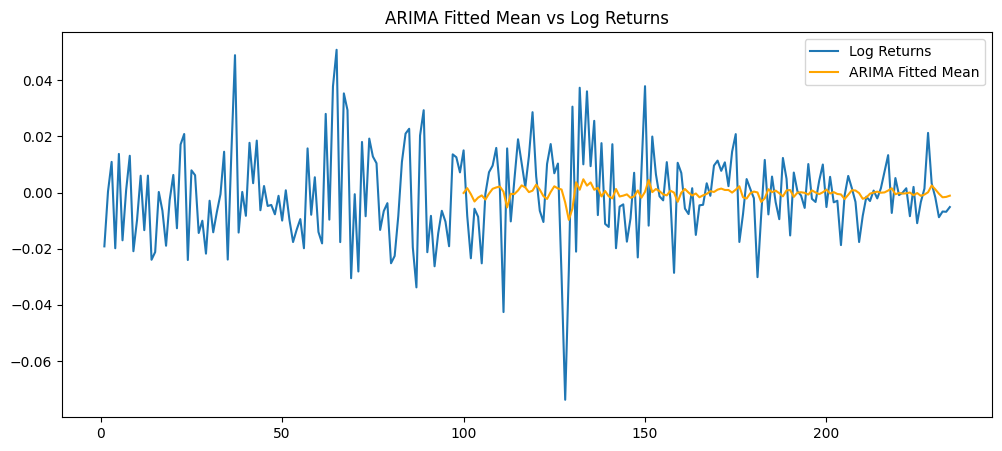

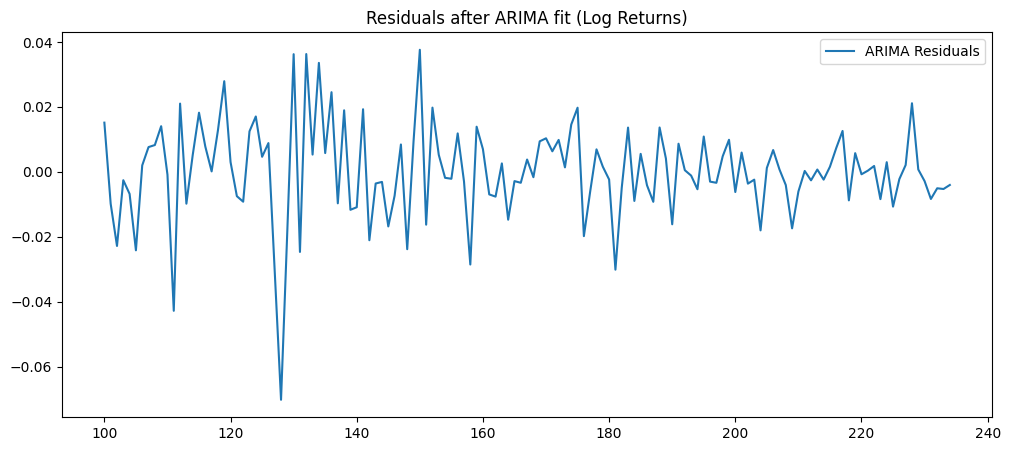

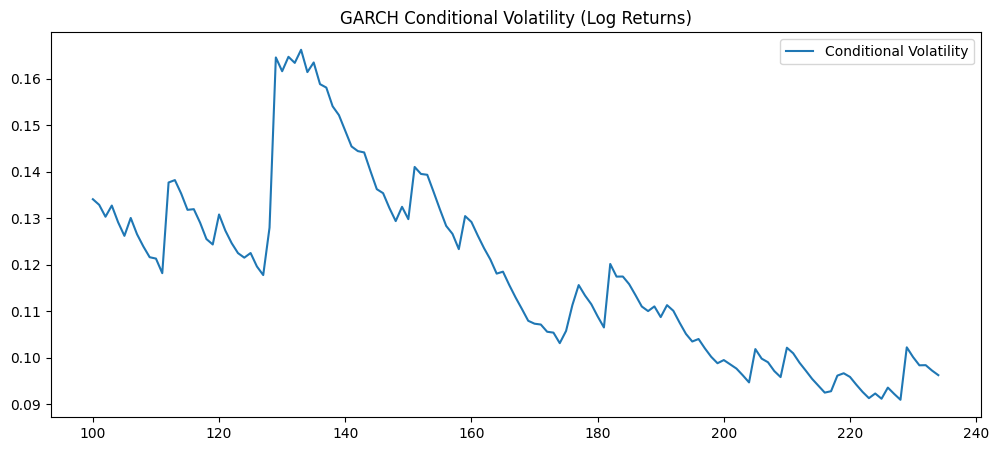

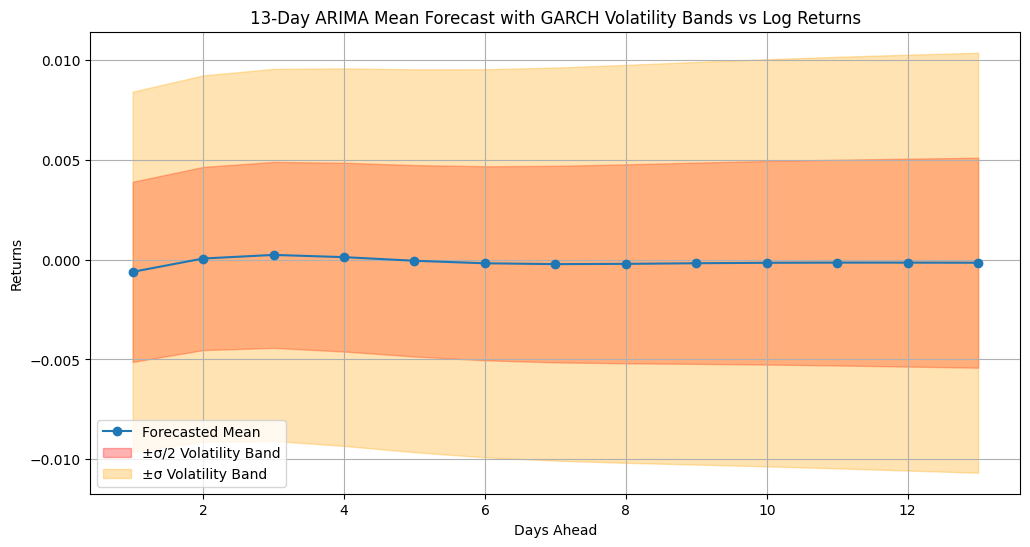

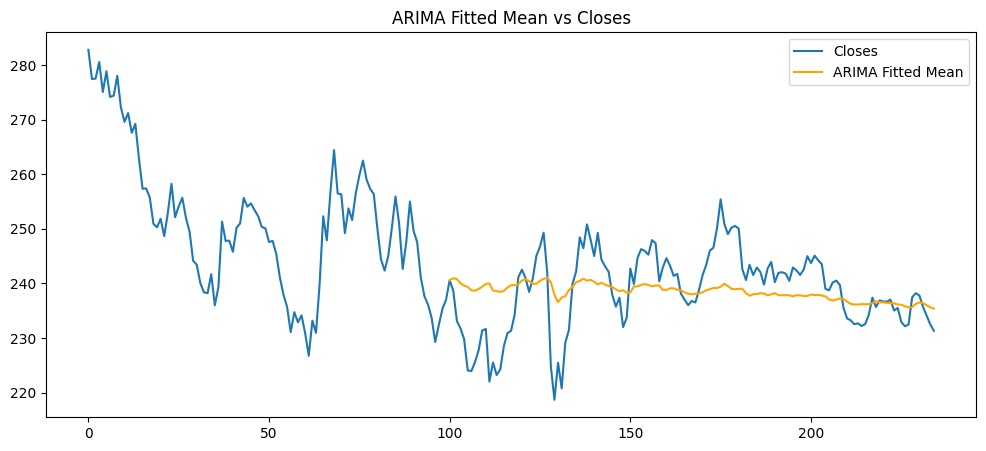

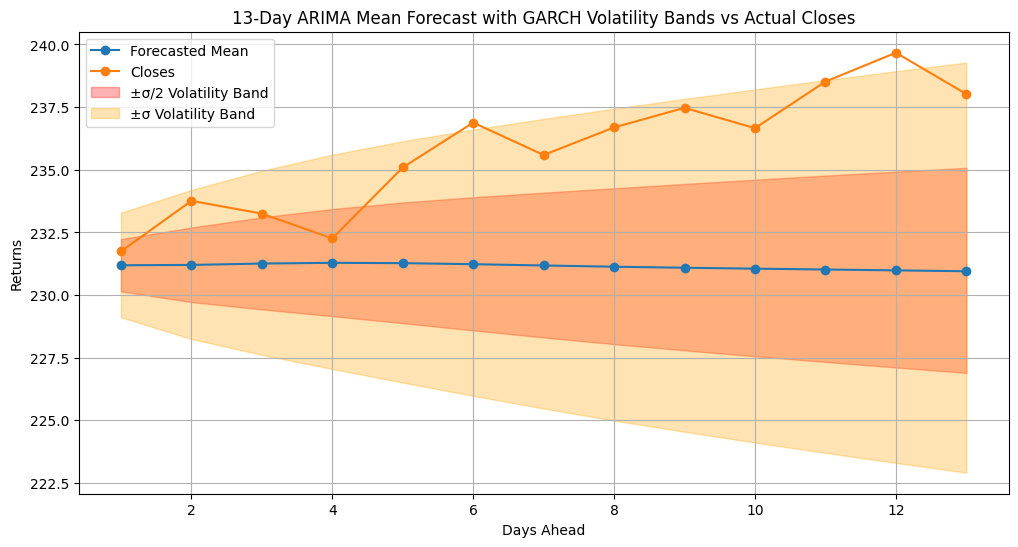


Forecasted mean (ARIMA) for next 13 days:
135   -0.000611
136    0.000057
137    0.000238
138    0.000126
139   -0.000056
140   -0.000182
141   -0.000224
142   -0.000210
143   -0.000180
144   -0.000156
145   -0.000147
146   -0.000148
147   -0.000153
Name: predicted_mean, dtype: float64

Forecasted volatility (GARCH) for next 13 days:
[0.00902323 0.00917231 0.00931609 0.00945487 0.00958893 0.00971851
 0.00984385 0.00996515 0.01008261 0.0101964  0.0103067  0.01041367
 0.01051744]


In [ ]:

# Days ahead for x-axis
days_ahead = np.arange(1, forecast_horizon + 1)

# Upper and lower bands (1 standard deviations)
upper_band1 = arima_mean_forecast + 0.5 * garch_vol_forecast
lower_band1 = arima_mean_forecast - 0.5 * garch_vol_forecast
upper_band2 = arima_mean_forecast + garch_vol_forecast
lower_band2 = arima_mean_forecast - garch_vol_forecast

# cumulative volatility for cumulative returns
cum_var = np.cumsum(garch_vol_forecast**2)
cum_vol = np.sqrt(cum_var)

upper_band1_prices = np.exp(np.log(last_price) + arima_mean_forecast.cumsum() + 0.5 * cum_vol)
lower_band1_prices = np.exp(np.log(last_price) + arima_mean_forecast.cumsum() - 0.5 * cum_vol)
upper_band2_prices = np.exp(np.log(last_price) + arima_mean_forecast.cumsum() + cum_vol)
lower_band2_prices = np.exp(np.log(last_price) + arima_mean_forecast.cumsum() - cum_vol)

# Plots

# Log prices, values

plt.figure(figsize=(12,5))
plt.plot(log_returns, label="Log Returns")
plt.plot(arima_result.fittedvalues, color='orange', label="ARIMA Fitted Mean")
plt.title("ARIMA Fitted Mean vs Log Returns")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(residuals, label="ARIMA Residuals")
plt.title("Residuals after ARIMA fit (Log Returns)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(np.sqrt(garch_result.conditional_volatility), label="Conditional Volatility")
plt.title("GARCH Conditional Volatility (Log Returns)")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(days_ahead, arima_mean_forecast, marker='o', label='Forecasted Mean')
plt.fill_between(days_ahead, lower_band1, upper_band1, color='red', alpha=0.3, label='±σ/2 Volatility Band')
plt.fill_between(days_ahead, lower_band2, upper_band2, color='orange', alpha=0.3, label='±σ Volatility Band')
plt.title(f"{forecast_horizon}-Day ARIMA Mean Forecast with GARCH Volatility Bands vs Log Returns")
plt.xlabel("Days Ahead")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

# Actual prices, exp(values)

plt.figure(figsize=(12,5))
plt.plot(train, label="Closes")
plt.plot(arima_fitted_prices, color='orange', label="ARIMA Fitted Mean")
plt.title("ARIMA Fitted Mean vs Closes")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(days_ahead, arima_forecasted_prices, marker='o', label='Forecasted Mean')
plt.plot(days_ahead, test, marker='o', label='Closes')
plt.fill_between(days_ahead, lower_band1_prices, upper_band1_prices, color='red', alpha=0.3, label='±σ/2 Volatility Band')
plt.fill_between(days_ahead, lower_band2_prices, upper_band2_prices, color='orange', alpha=0.3, label='±σ Volatility Band')
plt.title(f"{forecast_horizon}-Day ARIMA Mean Forecast with GARCH Volatility Bands vs Actual Closes")
plt.xlabel("Days Ahead")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

print("\nForecasted mean (ARIMA) for next", forecast_horizon, "days:")
print(arima_mean_forecast)

print("\nForecasted volatility (GARCH) for next", forecast_horizon, "days:")
print(garch_vol_forecast)


# ARIMA-GARCH Forecaster

### Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from arch.data import sp500
import warnings
warnings.filterwarnings("ignore")

### ARIMA-GARCH class

In [ ]:
class ARIMA_GARCH:
    def __init__(self, data):
        self.data = data

    def setPeriods(self, testPeriod=None, arimaPeriod=None, garchPeriod=None):
        self.train, self.test = np.split(self.data['Close'], [len(self.data) - testPeriod])
        self.log_prices = np.log(self.train)
        self.log_returns = self.log_prices.diff().dropna()

        self.arimaPeriod = arimaPeriod
        self.garchPeriod = garchPeriod

    def fitARIMA(self, arimaParameterSelect='AIC', verbose=False):
        # Determining d via ADF
        # True if stationary
        def adf_test(series, alpha=0.05):
            result = adfuller(series, autolag=arimaParameterSelect)
            pval = result[1]
            return pval < alpha

        d = 0
        series = self.log_returns.iloc[-1*self.arimaPeriod:].copy()
        while not adf_test(series):
            d += 1
            series = series.diff().dropna()

        if verbose: print(f"Optimal differencing order determined: d = {d}")

        # Determining (p,_,q) via AIC/BIC
        p_max = 10
        q_max = 10
        best_aic = np.inf
        best_bic = np.inf
        best_arima_order_aic = None
        best_arima_order_bic = None

        for p in range(1, p_max+1):
            for q in range(1, q_max+1):
                try:
                    model = sm.tsa.ARIMA(self.log_returns.iloc[-1*self.arimaPeriod:], order=(p,d,q))
                    result = model.fit()
                    if result.aic < best_aic:
                        best_aic = result.aic
                        best_arima_order_aic = (p,d,q)
                    if result.bic < best_bic:
                        best_bic = result.bic
                        best_arima_order_bic = (p,d,q)
                except:
                    continue

        if verbose:
            print(f"Optimal ARIMA order determined: {best_arima_order_aic} with AIC={best_aic:.2f}")
            print(f"Optimal ARIMA order determined: {best_arima_order_bic} with BIC={best_bic:.2f}")

        if arimaParameterSelect=='AIC':
            self.best_arima_order = best_arima_order_aic
        else:
            self.best_arima_order = best_arima_order_bic

        # Fitting ARIMA
        self.arima_model = sm.tsa.ARIMA(self.log_returns.iloc[-1*self.arimaPeriod:], order=self.best_arima_order)
        self.arima_result = self.arima_model.fit()
        self.residuals = self.arima_result.resid.dropna()

    def fitGARCH(self, garchParameterSelect='AIC', verbose=False):
        # Determining (p,q) via AIC/BIC
        garch_p_max = 10
        garch_q_max = 10
        best_aic_garch = np.inf
        best_bic_garch = np.inf
        best_garch_order_aic = None
        best_garch_order_bic = None

        for p in range(1, garch_p_max+1):  # p>=1 in GARCH
            for q in range(1, garch_q_max+1):  # q>=1 in GARCH
                try:
                    model = arch_model(self.residuals.iloc[-1*self.garchPeriod:], vol="GARCH", p=p, q=q, mean="Zero")
                    result = model.fit(disp="off")
                    if result.aic < best_aic_garch:
                        best_aic_garch = result.aic
                        best_garch_order_aic = (p,q)
                    if result.bic < best_bic_garch:
                        best_bic_garch = result.bic
                        best_garch_order_bic = (p,q)
                except:
                    continue

        if verbose:
            print(f"Optimal GARCH order determined: {best_garch_order_aic} with AIC={best_aic_garch:.2f}")
            print(f"Optimal GARCH order determined: {best_garch_order_bic} with BIC={best_bic_garch:.2f}")

        if garchParameterSelect=='AIC':
            self.best_garch_order = best_garch_order_aic
        else:
            self.best_garch_order = best_garch_order_bic

        # Fitting GARCH
        self.garch_model = arch_model(self.residuals.iloc[-1*self.garchPeriod:], vol="GARCH", p=self.best_garch_order[0], q=self.best_garch_order[1], mean="Zero")
        self.garch_result = self.garch_model.fit(disp="off")

    def forecastARIMA(self):
        # Forecast horizon
        forecast_horizon = len(self.test)

        # Forecasted mean (ARIMA)
        self.arima_forecast = self.arima_result.get_forecast(steps=forecast_horizon)
        self.arima_mean_forecast = self.arima_forecast.predicted_mean

        first_price = self.train.iloc[-1*self.arimaPeriod]
        last_price = self.train.iloc[-1]
        self.arima_fitted_prices = np.exp(np.log(first_price) + self.arima_result.fittedvalues.cumsum())
        self.arima_forecasted_prices = np.exp(np.log(last_price) + self.arima_mean_forecast.cumsum())

    def forecastGARCH(self):
        # Forecast horizon
        forecast_horizon = len(self.test)

        # Forecasted volatility (GARCH)
        self.garch_forecast = self.garch_result.forecast(horizon=forecast_horizon)
        self.garch_vol_forecast = np.sqrt(self.garch_forecast.variance.values[-1, :])

    def forecastPricesMSE(self):
        return np.mean((self.test.values - self.arima_forecasted_prices.values) ** 2)

    def runARIMA(self, testPeriod, arimaPeriod, arimaParameterSelect, verbose=False):
        self.setPeriods(testPeriod, arimaPeriod)
        self.fitARIMA(arimaParameterSelect, verbose)
        self.forecastARIMA()
        return self.forecastPricesMSE()

### Tuning ARIMA for AIC and BIC

In [ ]:
testp = 15

data = pd.read_csv('ONGC_Adjusted.csv')
forecaster = ARIMA_GARCH(data)

best_period_by_AIC = 0
best_pdq_by_AIC = None
best_error_by_AIC = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, 'AIC')
    if current<best_error_by_AIC:
        best_error_by_AIC = current
        best_period_by_AIC = period
        best_pdq_by_AIC = forecaster.best_arima_order
    print(f'AIC Instances: {period/15}/15')

print(f'Best period for AIC: {best_period_by_AIC}\n(p,d,q) determined: {best_pdq_by_AIC}\nerror: {best_error_by_AIC}')

best_period_by_BIC = 0
best_pdq_by_BIC = None
best_error_by_BIC = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, 'BIC')
    if current<best_error_by_BIC:
        best_error_by_BIC = current
        best_period_by_BIC = period
        best_pdq_by_BIC = forecaster.best_arima_order
    print(f'BIC Instances: {period/15}/15')

print(f'Best period for AIC: {best_period_by_AIC}\n(p,d,q) determined: {best_pdq_by_AIC}\nerror: {best_error_by_AIC}')
print(f'Best period for BIC: {best_period_by_BIC}\n(p,d,q) determined: {best_pdq_by_BIC}\nerror: {best_error_by_BIC}')



AIC Instances: 1.0/15
AIC Instances: 2.0/15
AIC Instances: 3.0/15
AIC Instances: 4.0/15
AIC Instances: 5.0/15
AIC Instances: 6.0/15
AIC Instances: 7.0/15
AIC Instances: 8.0/15
AIC Instances: 9.0/15
AIC Instances: 10.0/15
AIC Instances: 11.0/15
AIC Instances: 12.0/15
AIC Instances: 13.0/15
AIC Instances: 14.0/15
AIC Instances: 15.0/15
Best period for AIC: 135
(p,d,q) determined: (2, 0, 2)
error: 3.454873032492702
BIC Instances: 1.0/15
BIC Instances: 2.0/15
BIC Instances: 3.0/15
BIC Instances: 4.0/15
BIC Instances: 5.0/15
BIC Instances: 6.0/15
BIC Instances: 7.0/15
BIC Instances: 8.0/15
BIC Instances: 9.0/15
BIC Instances: 10.0/15
BIC Instances: 11.0/15
BIC Instances: 12.0/15
BIC Instances: 13.0/15
BIC Instances: 14.0/15
BIC Instances: 15.0/15
Best period for AIC: 135
(p,d,q) determined: (2, 0, 2)
error: 3.454873032492702
Best period for BIC: 135
(p,d,q) determined: (2, 0, 2)
error: 3.454873032492702


# Switched Up for AIC, BIC, ACF, PACF

In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from arch import arch_model

class ARIMA_GARCH:
    def __init__(self, data):
        self.data = data

    def setPeriods(self, testPeriod=None, arimaPeriod=None, garchPeriod=None):
        self.train, self.test = np.split(self.data['Close'], [len(self.data) - testPeriod])
        self.log_prices = np.log(self.train)
        self.log_returns = self.log_prices.diff().dropna()
        self.arimaPeriod = arimaPeriod
        self.garchPeriod = garchPeriod

    def _adf_test(self, series, autolag='AIC', alpha=0.05):
        result = adfuller(series, autolag=autolag)
        return result[1] < alpha

    def _determine_d(self):
        d = 0
        series = self.log_returns.iloc[-1*self.arimaPeriod:].copy()
        while not self._adf_test(series):
            d += 1
            series = series.diff().dropna()
        return d, series

    def select_order_aic(self, d, series, p_max=10, q_max=10):
        best_aic = np.inf
        best_order = None
        for p in range(1, p_max+1):
            for q in range(1, q_max+1):
                try:
                    model = sm.tsa.ARIMA(series, order=(p, d, q))
                    result = model.fit()
                    if result.aic < best_aic:
                        best_aic = result.aic
                        best_order = (p, d, q)
                except:
                    continue
        return best_order, best_aic

    def select_order_bic(self, d, series, p_max=10, q_max=10):
        best_bic = np.inf
        best_order = None
        for p in range(1, p_max+1):
            for q in range(1, q_max+1):
                try:
                    model = sm.tsa.ARIMA(series, order=(p, d, q))
                    result = model.fit()
                    if result.bic < best_bic:
                        best_bic = result.bic
                        best_order = (p, d, q)
                except:
                    continue
        return best_order, best_bic

    def suggest_order_acf(self, series, nlags=20, threshold=0.2):
        acf_vals = acf(series, nlags=nlags)
        for q in range(1, len(acf_vals)):
            if abs(acf_vals[q]) < threshold:
                return 0, q-1  # p=0, q based on ACF cutoff
        return 0, 1

    def suggest_order_pacf(self, series, nlags=20, threshold=0.2):
        pacf_vals = pacf(series, nlags=nlags)
        for p in range(1, len(pacf_vals)):
            if abs(pacf_vals[p]) < threshold:
                return p-1, 0  # p based on PACF cutoff, q=0
        return 1, 0

    def fitARIMA(self, method='AIC', verbose=False):
        d, series = self._determine_d()
        if verbose:
            print(f"Optimal differencing order determined: d = {d}")

        if method == 'AIC':
            order, val = self.select_order_aic(d, series)
            if verbose:
                print(f"Selected ARIMA order by AIC: {order}, AIC={val:.2f}")
        elif method == 'BIC':
            order, val = self.select_order_bic(d, series)
            if verbose:
                print(f"Selected ARIMA order by BIC: {order}, BIC={val:.2f}")
        elif method == 'ACF':
            p, q = self.suggest_order_acf(series)
            order = (p, d, q)
            if verbose:
                print(f"Suggested ARIMA order by ACF: {order}")
        elif method == 'PACF':
            p, q = self.suggest_order_pacf(series)
            order = (p, d, q)
            if verbose:
                print(f"Suggested ARIMA order by PACF: {order}")
        else:
            raise ValueError("Method must be one of 'AIC', 'BIC', 'ACF', or 'PACF'")

        self.best_arima_order = order
        self.arima_model = sm.tsa.ARIMA(series, order=order)
        self.arima_result = self.arima_model.fit()
        self.residuals = self.arima_result.resid.dropna()

    def fitGARCH(self, garchParameterSelect='AIC', verbose=False):
        garch_p_max = 10
        garch_q_max = 10
        best_aic_garch = np.inf
        best_bic_garch = np.inf
        best_garch_order_aic = None
        best_garch_order_bic = None

        for p in range(1, garch_p_max+1):
            for q in range(1, garch_q_max+1):
                try:
                    model = arch_model(self.residuals.iloc[-1*self.garchPeriod:], vol="GARCH", p=p, q=q, mean="Zero")
                    result = model.fit(disp="off")
                    if result.aic < best_aic_garch:
                        best_aic_garch = result.aic
                        best_garch_order_aic = (p, q)
                    if result.bic < best_bic_garch:
                        best_bic_garch = result.bic
                        best_garch_order_bic = (p, q)
                except:
                    continue

        if verbose:
            print(f"Optimal GARCH order determined: {best_garch_order_aic} with AIC={best_aic_garch:.2f}")
            print(f"Optimal GARCH order determined: {best_garch_order_bic} with BIC={best_bic_garch:.2f}")

        if garchParameterSelect == 'BIC':
            self.best_garch_order = best_garch_order_bic
        else:
            self.best_garch_order = best_garch_order_aic

        self.garch_model = arch_model(self.residuals.iloc[-1*self.garchPeriod:], vol="GARCH",
                                      p=self.best_garch_order[0], q=self.best_garch_order[1], mean="Zero")
        self.garch_result = self.garch_model.fit(disp="off")

    def forecastARIMA(self):
        forecast_horizon = len(self.test)
        self.arima_forecast = self.arima_result.get_forecast(steps=forecast_horizon)
        self.arima_mean_forecast = self.arima_forecast.predicted_mean

        first_price = self.train.iloc[-1*self.arimaPeriod]
        last_price = self.train.iloc[-1]
        self.arima_fitted_prices = np.exp(np.log(first_price) + self.arima_result.fittedvalues.cumsum())
        self.arima_forecasted_prices = np.exp(np.log(last_price) + self.arima_mean_forecast.cumsum())

    def forecastGARCH(self):
        forecast_horizon = len(self.test)
        self.garch_forecast = self.garch_result.forecast(horizon=forecast_horizon)
        self.garch_vol_forecast = np.sqrt(self.garch_forecast.variance.values[-1, :])

    def forecastPricesMSE(self):
        return np.mean((self.test.values - self.arima_forecasted_prices.values) ** 2)

    def runARIMA(self, testPeriod, arimaPeriod, method='AIC', verbose=False):
        self.setPeriods(testPeriod, arimaPeriod)
        self.fitARIMA(method, verbose)
        self.forecastARIMA()
        return self.forecastPricesMSE()


In [ ]:
import numpy as np
import pandas as pd

testp = 15
data = pd.read_csv('ONGC_Adjusted.csv')
forecaster = ARIMA_GARCH(data)

# For AIC
best_period_by_AIC = 0
best_pdq_by_AIC = None
best_error_by_AIC = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, method='AIC')
    if current < best_error_by_AIC:
        best_error_by_AIC = current
        best_period_by_AIC = period
        best_pdq_by_AIC = forecaster.best_arima_order
    print(f'AIC Instances: {period//15}/15')

print(f'Best period for AIC: {best_period_by_AIC}\n(p,d,q) determined: {best_pdq_by_AIC}\nerror: {best_error_by_AIC}')

# For BIC
best_period_by_BIC = 0
best_pdq_by_BIC = None
best_error_by_BIC = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, method='BIC')
    if current < best_error_by_BIC:
        best_error_by_BIC = current
        best_period_by_BIC = period
        best_pdq_by_BIC = forecaster.best_arima_order
    print(f'BIC Instances: {period//15}/15')

print(f'Best period for BIC: {best_period_by_BIC}\n(p,d,q) determined: {best_pdq_by_BIC}\nerror: {best_error_by_BIC}')

# For ACF
best_period_by_ACF = 0
best_pdq_by_ACF = None
best_error_by_ACF = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, method='ACF')
    if current < best_error_by_ACF:
        best_error_by_ACF = current
        best_period_by_ACF = period
        best_pdq_by_ACF = forecaster.best_arima_order
    print(f'ACF Instances: {period//15}/15')

print(f'Best period for ACF: {best_period_by_ACF}\n(p,d,q) determined: {best_pdq_by_ACF}\nerror: {best_error_by_ACF}')

# For PACF
best_period_by_PACF = 0
best_pdq_by_PACF = None
best_error_by_PACF = np.inf
for period in range(15, 231, 15):
    current = forecaster.runARIMA(testp, period, method='PACF')
    if current < best_error_by_PACF:
        best_error_by_PACF = current
        best_period_by_PACF = period
        best_pdq_by_PACF = forecaster.best_arima_order
    print(f'PACF Instances: {period//15}/15')

print(f'Best period for PACF: {best_period_by_PACF}\n(p,d,q) determined: {best_pdq_by_PACF}\nerror: {best_error_by_PACF}')


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use 

AIC Instances: 1/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 2/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 3/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

AIC Instances: 4/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 5/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 6/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

AIC Instances: 7/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 8/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

AIC Instances: 9/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 10/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 11/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

AIC Instances: 12/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

AIC Instances: 13/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

AIC Instances: 14/15


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot